# SPAHR MODEL WITH MESA

Links

* https://github.com/projectmesa/mesa/blob/master/examples/virus_on_network/virus_on_network/model.py
* https://networkx.github.io/documentation/stable/reference/drawing.html
* https://stackoverflow.com/questions/63681056/visualizing-agents-using-mesa-networkx

In [1]:
import time, enum, math
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

import networkx as nx

from collections import Counter

/var/folders/bz/kgjq5nj504zdxr15gz707scc0000gn/T/ipykernel_47434/3903283465.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension()

Loading BokehJS ...

In [3]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    PRESCRIBED = 1
    ADDICTION = 2
    HEROIN_AD = 3
    RECOVERED = 4
    REMOVED = 5
    

In [36]:
def relapse(g1, g2, sigma, w):
    if g1 == 0 and g2 == 0:
        return sigma/2
    return sigma * g1 / (g1 + g2 + w)


class SPAHRAgent(Agent): 
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.state = State.SUSCEPTIBLE


    def step(self):
        '''Method to update the state of a given node'''
        # neighbors of every node
        if self.state == State.REMOVED:
            # Temporary fix
            self.model.counts[self.state] -= 1
            self.state=State.SUSCEPTIBLE
            self.model.counts[self.state] += 1

            # INCLUDE method of removing node and adding a new node connected to graph

        neighbors_nodes = self.model.grid.get_neighbors(self.pos, 
                                                include_center = False)
        
        varsSol = self.transitionVars(neighbors_nodes)
        sols = np.array(list(varsSol.values())) # each transtion variables calculations
        lam = np.sum(sols) # the total of all the transition variables calculations
        tr_probs = sols / lam  # each variables contribution normalized by lambda
        p_transition = 1 - math.e ** (-lam * self.model.tstep) # probability of transition

        # transition occurs
        if np.random.rand() < p_transition: 
            choice = np.random.choice(list(varsSol.keys()), p = tr_probs) # choose which group to transition to based on transition probabilities

            self.model.counts[self.state] -= 1
            self.state = choice.destination # make choice new destination
            self.model.counts[self.state] += 1


    def transitionVars(self, neighbor_list):
        '''given list of neighbors returns a dictionary with entries transition_var : calculated contribution to Lambda'''
        k = len(neighbor_list) * 1.0
        
        neighbor_counts = dict(Counter([agent.state for agent in neighbor_list]))

        neighbor_densities = {State(state): 0 for state in range(6)} # start with every neighbor presents = 0

        for state in neighbor_counts.keys(): # calculate existing neighbor densities
            neighbor_densities[state] = neighbor_counts[state] / k

        global_densities = {State(state): self.model.counts[state] / (self.model.n - 1) for state in range(6)} # needed in some cases where no neighbors exist
        possible = self.model.transitions[self.state] # possible transitions from current state
        varsSol = {tvr: tvr.func(neighbor_densities, global_densities) for tvr in possible}

        return varsSol

        
    def toJSON(self):        
        d = self.unique_id
        return json.dumps(d, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)

In [37]:
default_data = {"n": 2000, "drate": 0.0071, "tstep": 0.01, "od_rateA": 0.00883, "od_rateH": 0.0466, "S2P": 0.27, "P2S": 2.53, "S2H": 0.222, "S2A_A": 0.000878, "S2A_P": 0.0000654, "P2A": 0.00505, "P2H": 0.236, "A2H": 19.7, "A2R":  0.198, "H2R": 0.000531, "sigma": 0.102, "omega": 0.0001, "S0": 0.892365, "P0": 0.095, "A0": 0.0071, "H0": 0.000465, "R0": 0.00507}

class trVar(Model):
    """A class for transion variables"""

    def __init__(self, value, destination, linear = True, func = None):
        self.value = value
        self.destination = destination
        self.linear = linear

        # create a function to get the variables contribution to lambda
        if linear:
            # linear function just returns its value
            self.func = lambda ldata, gdata: self.value

        else:
            if func == None:
                # standard non-linear function that mutliplies its value by the density of neighbors in the destination group
                self.func = lambda ldata, gdata: ldata[destination] * self.value 
            else:
                # the last case is if we have created a custom function for this calculation
                self.func = func

class SPAHRModel(Model):
    """A model for infection spread."""
    
    def __init__(self, G, data = default_data):

        # The network x network
        self.G = G
        
        self.grid = NetworkGrid(self.G)
        
        # Basic Params:
        self.n = G.number_of_nodes()
        self.tstep = data["tstep"] # timestep

        # The list of rate variables we may need (comments are the variable names in the paper)
        # _______________________Transition Variables______________________________
        # Linear Transition variables:
        self.drate = trVar(data["drate"], State.REMOVED)        # µ
        self.od_rateA = trVar(data["od_rateA"], State.REMOVED)  # µ_A
        self.od_rateH = trVar(data["od_rateH"], State.REMOVED)  # µ_H
        self.S2P = trVar(data["S2P"], State.PRESCRIBED)         # alpha
        self.P2S = trVar(data["P2S"], State.SUSCEPTIBLE)        # epsilon
        self.P2A = trVar(data["P2A"], State.ADDICTION)          # Gamma
        self.A2R = trVar(data["A2R"] , State.RECOVERED)         # Zeta
        self.H2R = trVar(data["H2R"], State.RECOVERED)          # v
        # self.R2A = trVar(data["sigma"], State.ADDICTION)        # sigma for R2A transition
        # self.R2H = trVar(data["sigma"], State.HEROIN_AD)        # sigma for R2H transition

        # Non-Linear Transition variables:
        self.S2H = trVar(data["S2H"] , State.HEROIN_AD, linear=False)      # Theta_1
        self.S2A_A = trVar(data["S2A_A"], State.ADDICTION, linear=False)   # Beta_A
        self.P2H = trVar(data["P2H"], State.HEROIN_AD, linear=False)       # Theta_2
        self.A2H = trVar(data["A2H"], State.HEROIN_AD, linear=False)       # Theta_3

        # other transition variables (special cases)
        self.S2A_P = trVar(data["S2A_P"], State.ADDICTION, linear = False, func = lambda ldata, gdata: ldata[State.PRESCRIBED] * data["S2A_A"])        # Beta_p
        self.R2A = trVar(data["sigma"], State.ADDICTION, linear=False, func = lambda ldata, gdata: relapse(gdata[State.ADDICTION], gdata[State.HEROIN_AD], data["sigma"], data["omega"]))        # sigma for R2A transition
        self.R2H = trVar(data["sigma"], State.HEROIN_AD, linear=False,func = lambda ldata, gdata: relapse(gdata[State.HEROIN_AD], gdata[State.ADDICTION], data["sigma"], data["omega"]))        # sigma for R2H transition
        #_________________________________________________________________________________

        # Starting population distribution
        self.S0 = data["S0"]
        self.P0 = data["P0"]
        self.A0 = data["A0"]
        self.H0 = data["H0"]
        self.R0 = data["R0"]
        
        # each state stores its outward transition variables
        self.transitions = {
            State.SUSCEPTIBLE: [self.drate, self.S2A_A, self.S2A_P, self.S2H, self.S2P],
            State.PRESCRIBED:  [self.drate, self.P2A, self.P2H, self.P2S],
            State.ADDICTION:   [self.drate, self.od_rateA, self.A2H, self.A2R],
            State.HEROIN_AD:   [self.drate, self.od_rateH, self.H2R],
            State.RECOVERED:   [self.drate, self.R2A, self.R2H],
            State.REMOVED:     [] # removed should have its own case (fancy new node addition thing)
        }
        
        self.schedule = RandomActivation(self)
        self.running = True
        self.counts = {State(i): 0 for i in range(6)}
        
        # Create agents 
        for i, node in enumerate(self.G.nodes()): #_______________NEEEED TO MODIFY_________________
            a = SPAHRAgent(i+1, self)
            self.schedule.add(a)
            #add agent
            self.grid.place_agent(a, node)

            #make some agents infected at start # _________________HOW DO THEY INITIALIZE IN PAPER?______________
            initial_state = np.random.choice([0,1,2,3,4,5], p=[self.S0,self.P0, self.A0, self.H0, self.R0, 0])
            a.state = State(initial_state)
            self.counts[a.state] += 1

        self.datacollector = DataCollector(
            agent_reporters={"State": "state"})
        
        print("Groupings: ", self.counts)
         
    
    # def get_recovery_time(self):
    #     return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))
    
    def step(self):
        self.datacollector.collect(self)
        # print(len(self.schedule._agents)) # schedule is not empty
        self.schedule.step()

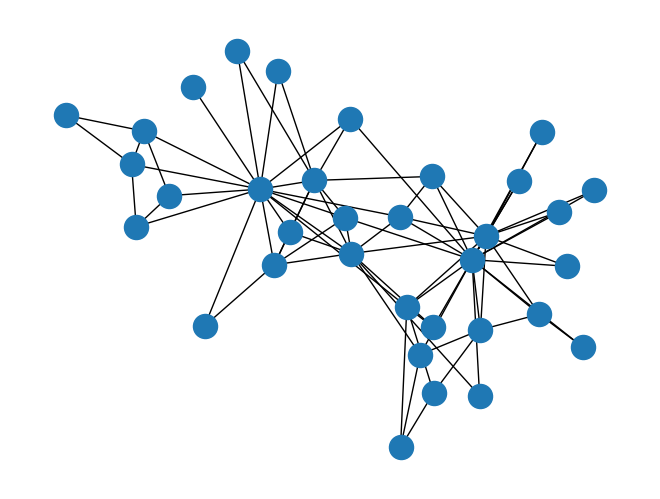

In [38]:
G = nx.karate_club_graph()
nx.draw(G)

In [39]:

model = SPAHRModel(G)
model.step()
model

Groupings:  {<State.SUSCEPTIBLE: 0>: 31, <State.PRESCRIBED: 1>: 3, <State.ADDICTION: 2>: 0, <State.HEROIN_AD: 3>: 0, <State.RECOVERED: 4>: 0, <State.REMOVED: 5>: 0}


/Users/theojulien/Library/Python/3.9/lib/python/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


In [23]:
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Perscribed','Addicted', 'Heroin Addict', 'Rehab', 'Removed']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=3,alpha=0.8)
    return f

In [40]:
G = nx.erdos_renyi_graph(n = 200, p = 0.01)
model = SPAHRModel(G)
steps = 50
st = time.time()
for i in range(steps):
    model.step()
print (time.time()-st)
agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:10])

Groupings:  {<State.SUSCEPTIBLE: 0>: 180, <State.PRESCRIBED: 1>: 18, <State.ADDICTION: 2>: 2, <State.HEROIN_AD: 3>: 0, <State.RECOVERED: 4>: 0, <State.REMOVED: 5>: 0}
0.14800119400024414
      Susceptible  Perscribed  Addicted
Step                                   
0             180          18         2
1             179          19         2
2             178          20         2
3             178          20         2
4             178          20         2
5             178          20         2
6             180          18         2
7             181          17         2
8             180          18         2
9             179          19         2


SOMETHING SEEMS WRONG, <br>
The addiction and herion groups stay suspitiously low

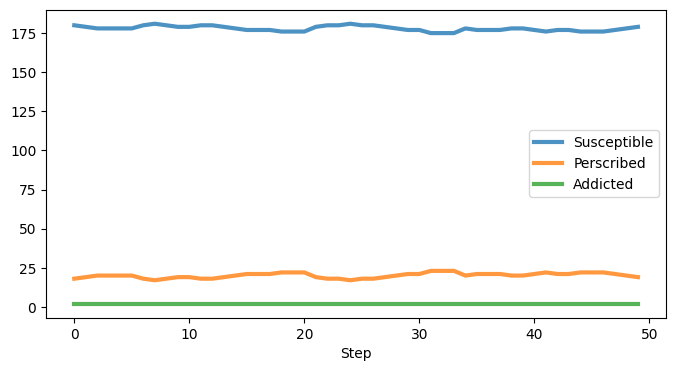

In [41]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SIR.png',dpi=150)

/Users/theojulien/Library/Python/3.9/lib/python/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


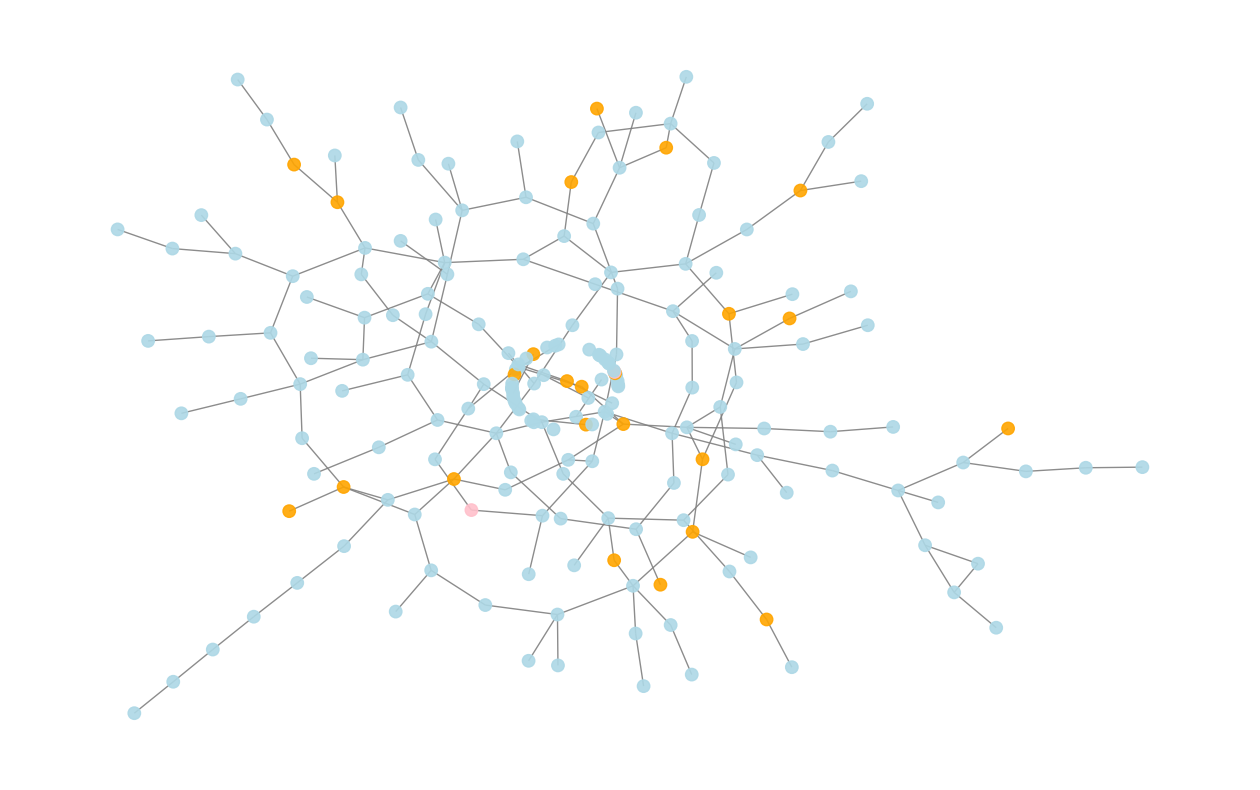

In [35]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = ListedColormap(["lightblue", "orange", "green", "purple", "pink", "yellow"])

def plot_grid(model,fig,layout='spring',title=''):
    graph = model.G
    if layout == 'kamada-kawai':      
        pos = nx.kamada_kawai_layout(graph)  
    elif layout == 'circular':
        pos = nx.circular_layout(graph)
    else:
        pos = nx.spring_layout(graph, iterations=5, seed=8)  
    plt.clf()
    ax=fig.add_subplot()
    states = [int(i.state) for i in model.grid.get_all_cell_contents()]

    #cells = [(i.pos,int(i.state)) for i in model.grid.get_all_cell_contents()]
    #print (cells[:10])
    #print (pos)
    #print (pd.Series(states).value_counts())
    colors = [cmap(i) for i in states]
    
    nx.draw(graph, pos, node_size=80, edge_color='gray', node_color=colors, #with_labels=True,
            alpha=0.9,font_size=14,ax=ax)
    #print (ax.patches)
    #ax.legend(['S','I','R'])
    ax.set_title(title)
    return

fig,ax=plt.subplots(1,1,figsize=(16,10))
model = SPAHRModel(G)
model.step();model.step()
f=plot_grid(model,fig,layout='kamada-kawai')
plt.savefig('abm_networkgrid.jpg')

Attempt with equal starting populations

In [51]:
G = nx.erdos_renyi_graph(n = 500, p = 3/(500-1))
mydata = default_data
mydata["S0"], mydata["P0"], mydata["A0"], mydata["H0"], mydata["R0"] = (0.2, 0.2, 0.2, 0.2, 0.2)
model = SPAHRModel(G, data=mydata)
steps = 50
st = time.time()

for i in range(steps):
    model.step()
print (time.time()-st)
agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:10])

/Users/theojulien/Library/Python/3.9/lib/python/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


Groupings:  {<State.SUSCEPTIBLE: 0>: 84, <State.PRESCRIBED: 1>: 104, <State.ADDICTION: 2>: 90, <State.HEROIN_AD: 3>: 106, <State.RECOVERED: 4>: 116, <State.REMOVED: 5>: 0}
0.605999231338501
      Susceptible  Perscribed  Addicted  Heroin Addict  Rehab  Removed
Step                                                                  
0              84         104        90            106    116        0
1              85         103        86            110    116        0
2              88         100        84            112    116        0
3              92          96        79            117    116        0
4              92          96        77            120    115        0
5              93          95        75            122    115        0
6              93          95        70            126    115        1
7              97          91        70            127    115        0
8             100          88        67            130    115        0
9             104          84

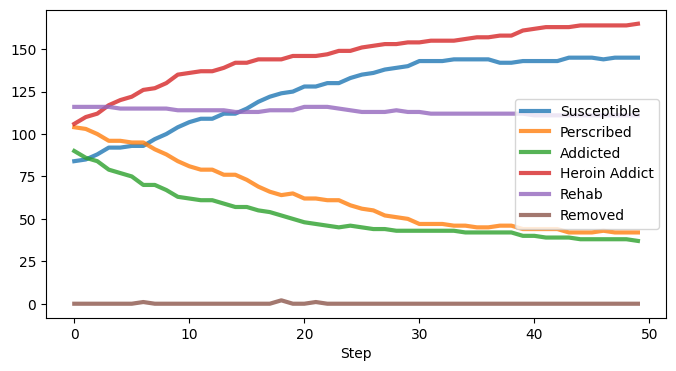

In [53]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SIR.png',dpi=150)

/Users/theojulien/Library/Python/3.9/lib/python/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


Groupings:  {<State.SUSCEPTIBLE: 0>: 92, <State.PRESCRIBED: 1>: 91, <State.ADDICTION: 2>: 104, <State.HEROIN_AD: 3>: 106, <State.RECOVERED: 4>: 107, <State.REMOVED: 5>: 0}


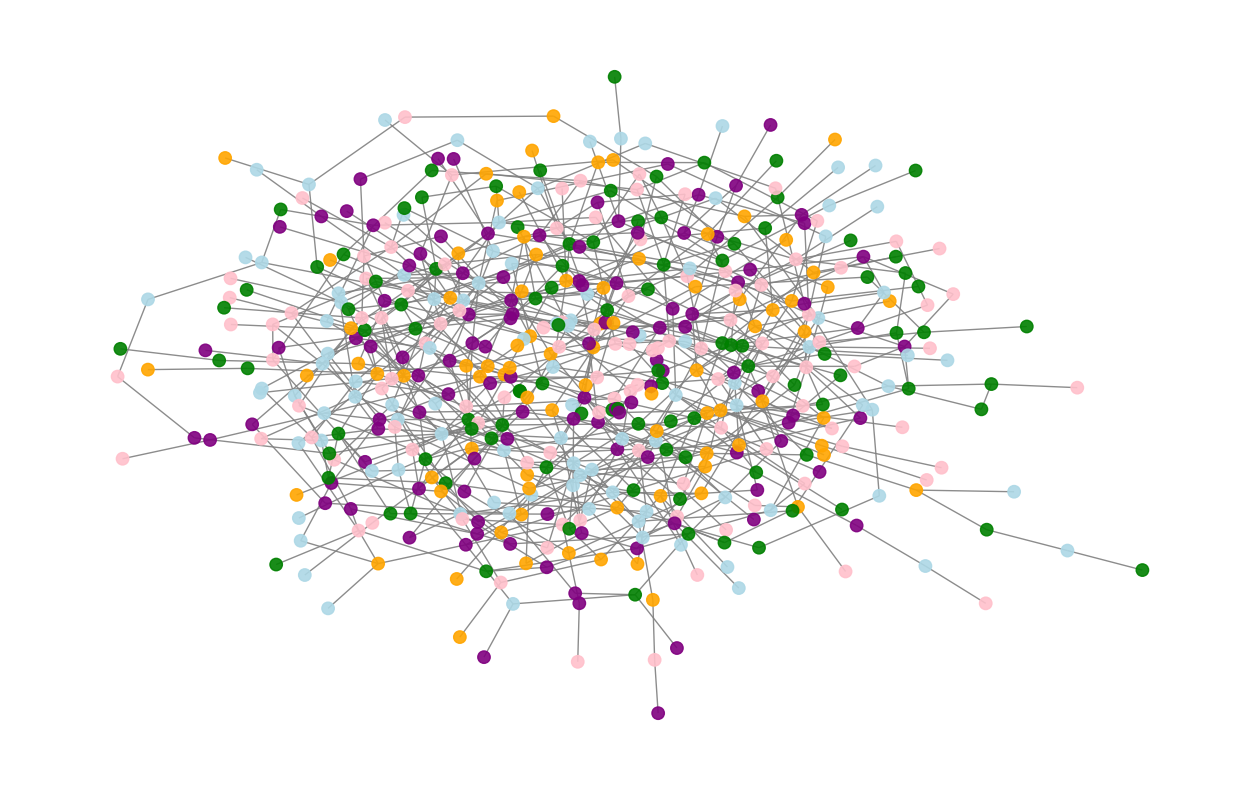

In [54]:
fig,ax=plt.subplots(1,1,figsize=(16,10))
model = SPAHRModel(G)
model.step();model.step()
f=plot_grid(model,fig,layout='kamada-kawai')
plt.savefig('abm_networkgrid.jpg')